In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from ortools.linear_solver import pywraplp

# Systems Simulation and Modeling Project

## Optimization Linear Programming
## Vehicle routing optimization

###### Objective function
We would want to minimize the total traveling distance of all vehicle
$$minimize \sum_{k=1}^{K} \sum_{i=0}^{N} \sum_{j=0}^{N} d_{ij}^{k}x_{ij}^{k}$$
###### constraint 1
Each location will be visited only once
$$\sum_{k=1}^{K}\sum_{i=0, i\ne j}^{N} x_{ij}^{k} = 1, \forall j=1,...,N$$
###### constraint 2
constraint 2 ensure that the initial point of each vehicle is the distribution center.
$$\sum_{j=1}^{N} x_{0j}^{k} = 1, \forall k$$
###### constraint 3
$$\sum_{i=0}^{N} x_{it}^{k} - \sum_{j=0}^{N} x_{tj}^{k} = 0, \forall k, \forall t$$
###### constraint 4
$$\sum_{i=0}^{N}\sum_{j=0}^{N} d_{ij}x_{ij}^{k} \leq D, \forall k$$

$$x_{ij}^{k} = 0, 1  \forall k, \forall i, \forall j$$
https://medium.com/jdsc-tech-blog/capacitated-vehicle-routing-problem-cvrp-with-python-pulp-and-google-maps-api-5a42dbb594c0
https://bib.irb.hr/datoteka/433524.Vehnicle_Routing_Problem.pdf

In [2]:
np.random.seed(777)
n = 20
vehicle_count = 1
locations_count = 10
max_distance = 100
locations = np.zeros((locations_count, 2))
count = 0
while(count < locations_count):
    x, y = np.random.randint(0, n-1), np.random.randint(0, n-1)
    xy = np.array([x,y])
    if not np.any(np.all(xy == locations, axis=1)): # if it is unique (x,y) coordinates, then add to locations
        locations[count] = [x,y] 
        count+=1

In [3]:
xs, ys = locations.T
center = locations[0]

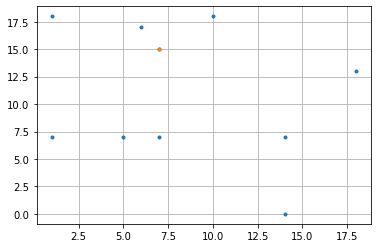

In [4]:
plt.plot(xs, ys, '.')
plt.plot(center[0], center[1], '.')
plt.grid()

In [5]:
def distance(p1, p2):
    x1, x2 = p1[0], p2[0]
    y1, y2 = p1[1], p2[1]
    return math.hypot(x2 - x1, y2 - y1)

In [6]:
distance_matrix = [[distance(locations[i], locations[j]) 
                    for i in range(locations_count)] 
                    for j in range(locations_count)]
distance_matrix

[[0.0,
  2.23606797749979,
  8.0,
  10.63014581273465,
  11.180339887498947,
  16.55294535724685,
  6.708203932499369,
  8.246211251235321,
  10.0,
  4.242640687119286],
 [2.23606797749979,
  0.0,
  10.04987562112089,
  12.806248474865697,
  12.649110640673518,
  18.788294228055936,
  5.099019513592785,
  10.04987562112089,
  11.180339887498949,
  4.123105625617661],
 [8.0,
  10.04987562112089,
  0.0,
  7.0,
  12.529964086141668,
  9.899494936611665,
  12.529964086141668,
  2.0,
  6.0,
  11.40175425099138],
 [10.63014581273465,
  12.806248474865697,
  7.0,
  0.0,
  7.211102550927979,
  7.0,
  17.029386365926403,
  9.0,
  13.0,
  11.704699910719626],
 [11.180339887498947,
  12.649110640673518,
  12.529964086141668,
  7.211102550927979,
  0.0,
  13.601470508735444,
  17.720045146669353,
  14.317821063276352,
  18.02775637731995,
  9.433981132056603],
 [16.55294535724685,
  18.788294228055936,
  9.899494936611665,
  7.0,
  13.601470508735444,
  0.0,
  22.203603311174515,
  11.401754250991

In [7]:
distance(center, locations[1])

2.23606797749979

In [8]:
print(center)
print(locations[1])

[ 7. 15.]
[ 6. 17.]


In [9]:
solver = pywraplp.Solver.CreateSolver('SAT')

# Decision variables
x = [[[solver.IntVar(0, 1, 'x_%s_%s,%s'%(i, j, k)) 
        for i in range(locations_count)] 
        for j in range(locations_count)] 
        for k in range(vehicle_count)]

# Objective function
objective_terms = [ distance_matrix[i][j] * x[k][i][j]
                   for i in range(locations_count) 
                   for j in range(locations_count) 
                   for k in range(vehicle_count) ]

solver.Minimize(solver.Sum(objective_terms))

In [10]:
# constraint 1
for j in range(1, locations_count):
    constraint1 = [ x[k][i][j]
                   for k in range(vehicle_count) 
                   for i in range(locations_count) if i!=j ]
    solver.Add(solver.Sum(constraint1) == 1)
    
# constraint 2
for k in range(vehicle_count):
    constraint3 = [x[k][0][j] for j in range(1, locations_count)]
    solver.Add(solver.Sum(constraint3) == 1)
    
# constraint 3
for k in range(vehicle_count):
    for t in range(locations_count):
        in_coming = [x[k][i][t] for i in range(locations_count) if i!=t]
        out_going = [x[k][t][j] for j in range(locations_count) if j!=t]
        solver.Add((solver.Sum(in_coming) - solver.Sum(out_going)) == 0)
        
# constraint 4
for k in range(vehicle_count):
    constraint4 = [ distance_matrix[i][j] * x[k][i][j] 
                   for i in range(locations_count)
                   for j in range(locations_count) ]
    solver.Add(solver.Sum(constraint4) <= max_distance)
    
# subtour elimination

In [11]:
solver.Solve()

0

In [12]:
solver.Objective().Value()

58.495893478393555

In [13]:
print(x[0][9][0].solution_value())

1.0


In [14]:
locations[9]

array([10., 18.])

In [15]:
def plot_graph():
    for k in range(vehicle_count):
        for i in range(locations_count):
            for j in range(locations_count):
                if i!=j and x[k][i][j].solution_value() == 1:
                    plt.plot([locations[i][0], locations[j][0]], [locations[i][1], locations[j][1]], c='black')
        

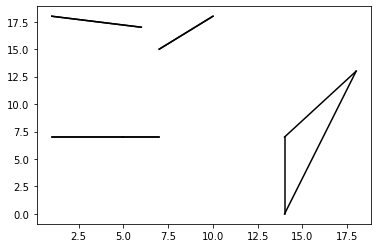

In [16]:
plot_graph()